<a href="https://colab.research.google.com/github/abxda/python/blob/main/UP_Semana_3_Viernes_y_S%C3%A1bado_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pandas geopandas seaborn tqdm requests

In [2]:
pip install geohexgrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 4.2 MB/s eta 0:00:00


In [3]:
import os
import time
from zipfile import ZipFile
import requests
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
from math import sin, cos, radians, sqrt
import geohexgrid as ghg
import matplotlib.pyplot as plt
import folium

### Explicación de la función `download`

Esta función está diseñada para descargar archivos desde internet, verificando primero si el archivo ya existe en el directorio local antes de proceder con la descarga. A continuación, se desglosa el código paso a paso para entender mejor su funcionamiento.

#### Definición de la función
```python
def download(url, directory):
```
- `download` es el nombre de la función.
- `url` es un parámetro de la función que espera una cadena de texto representando la URL del archivo que se desea descargar.
- `directory` es otro parámetro que indica el directorio local donde se guardará el archivo descargado.

#### Extracción del nombre del archivo
```python
filename = url.split('/')[-1]
```
- `url.split('/')` divide la URL en partes donde cada parte es separada por `/`. Esto crea una lista de todos los segmentos de la URL.
- `['-1']` selecciona el último elemento de la lista, que generalmente es el nombre del archivo en una URL estándar.

#### Creación de la ruta completa del archivo
```python
filepath = os.path.join(directory, filename)
```
- `os.path.join(directory, filename)` concatena el directorio con el nombre del archivo utilizando el separador de directorio adecuado para el sistema operativo en uso (por ejemplo, `/` en UNIX y `\` en Windows). Esto asegura que la ruta del archivo sea correcta sin importar el sistema operativo.

#### Verificación de la existencia del archivo
```python
if os.path.exists(filepath):
    print(f"El archivo {filename} ya existe, no se descarga de nuevo.")
    return
```
- `os.path.exists(filepath)` verifica si un archivo ya existe en la ruta especificada.
- Si el archivo existe, se imprime un mensaje indicando que el archivo ya existe y se termina la ejecución de la función con `return`, evitando realizar la descarga nuevamente.

#### Simulación de retardo y proceso de descarga
```python
time.sleep(5)  # Simular retardo en la red
```
- `time.sleep(5)` pausa la ejecución del programa por 5 segundos, simulando un retardo en la red como podría ocurrir en una situación real de descarga.

```python
r = requests.get(url, stream=True)
```
- `requests.get(url, stream=True)` realiza una solicitud HTTP GET para descargar el contenido del `url`. El argumento `stream=True` permite descargar el contenido en fragmentos, lo que es útil para archivos grandes.

```python
total_size = int(r.headers['content-length'])
```
- `r.headers['content-length']` obtiene la longitud del contenido desde los encabezados de la respuesta HTTP, que es la longitud total del archivo en bytes.
- `int()` convierte la longitud del contenido en un entero.

#### Escritura del archivo en partes
```python
with open(filepath, 'wb') as f:
```
- `open(filepath, 'wb')` abre el archivo en modo binario para escritura (`'wb'`). Esto es necesario para archivos no textuales como imágenes, música, etc.
- `as f` asigna el archivo abierto a la variable `f`.

```python
for data in tqdm(iterable=r.iter_content(chunk_size=1024), total=total_size / 1024, unit='KB'):
    f.write(data)
```
- `r.iter_content(chunk_size=1024)` genera los datos del archivo en partes (o "chunks") de 1024 bytes.
- `tqdm()` es un iterador que muestra una barra de progreso para visualizar el avance de la descarga.
- `total=total_size / 1024` y `unit='KB'` configuran la barra de progreso para mostrar el progreso en kilobytes.
- `f.write(data)` escribe cada parte del archivo en el disco.


In [4]:
def download(url, directory):
    filename = url.split('/')[-1]
    filepath = os.path.join(directory, filename)

    # Verificar si el archivo ya existe
    if os.path.exists(filepath):
        print(f"El archivo {filename} ya existe, no se descarga de nuevo.")
        return

    # Proceso de descarga
    time.sleep(5)  # Simular retardo en la red
    r = requests.get(url, stream=True)
    total_size = int(r.headers['content-length'])
    with open(filepath, 'wb') as f:
        for data in tqdm(iterable=r.iter_content(chunk_size=1024), total=total_size / 1024, unit='KB'):
            f.write(data)


### Explicación de la función `extract_shapefile`

Esta función está diseñada para extraer archivos específicos de un conjunto de archivos zip relacionados con datos geográficos, específicamente archivos shapefile y sus componentes asociados.

Esta función gestiona eficientemente la verificación y extracción de archivos necesarios para trabajar con datos geográficos shapefile, asegurando que no se realicen descompresiones innecesarias y manejando casos especiales como la ausencia del archivo `.cpg`.

Analicemos el código paso a paso para comprender cada uno de sus componentes.

#### Definición de la función
```python
def extract_shapefile(estados_geo, directory, shp_dir, shape_type):
```
- `extract_shapefile` es el nombre de la función.
- `estados_geo` es una lista de nombres de archivos zip, cada uno representando un estado o región geográfica.
- `directory` es el directorio donde están almacenados los archivos zip.
- `shp_dir` es el directorio donde se extraerán los archivos shapefile.
- `shape_type` es un sufijo o tipo que define el conjunto específico de archivos shapefile dentro de los zips.

#### Iteración sobre cada archivo zip
```python
for estado in estados_geo:
    file = estado.split('_')[0]
    zip_file = os.path.join(directory, estado)
```
- Se itera sobre cada elemento en `estados_geo`.
- `estado.split('_')[0]` extrae la parte inicial del nombre del archivo, que corresponde al identificador del estado o región, separado por un guion bajo `_`.
- `os.path.join(directory, estado)` genera la ruta completa al archivo zip combinando el directorio base con el nombre del archivo.

#### Lista de archivos necesarios
```python
shp_files = [
    f'conjunto_de_datos/{file}{shape_type}.shp',
    f'conjunto_de_datos/{file}{shape_type}.cpg',
    f'conjunto_de_datos/{file}{shape_type}.dbf',
    f'conjunto_de_datos/{file}{shape_type}.prj',
    f'conjunto_de_datos/{file}{shape_type}.shx'
]
```
- `shp_files` es una lista de rutas de archivos shapefile que se esperan encontrar dentro del zip. Estos incluyen archivos `.shp`, `.cpg`, `.dbf`, `.prj`, `.shx`, que son componentes estándar de un conjunto de datos geográficos shapefile.

#### Verificación de existencia de archivos
```python
if all(os.path.exists(os.path.join(shp_dir, f)) for f in shp_files):
    print(f"Todos los archivos para {file} ya están descomprimidos en {shp_dir}")
    continue
```
- `all()` verifica si todos los archivos listados en `shp_files` ya existen en el directorio `shp_dir`.
- Si todos los archivos ya están presentes, imprime un mensaje indicando esto y continúa con el siguiente archivo zip en la lista usando `continue`.

#### Proceso de descompresión
```python
with ZipFile(zip_file, 'r') as zip:
    for f in shp_files:
        try:
            zip.extract(f, shp_dir)
        except KeyError:
            if f.endswith('.cpg'):  # Archivo CPG es opcional
                with open(os.path.join(shp_dir, f), 'w') as out_file:
                    out_file.write("ISO 88591")
            else:
                print(f"El archivo {f} no se encontró en el ZIP.")
```
- `ZipFile(zip_file, 'r')` abre el archivo zip en modo lectura.
- Se itera sobre cada archivo en `shp_files` intentando extraerlo en `shp_dir`.
- Si un archivo no se encuentra (`KeyError`), se verifica si es un archivo `.cpg` (que es opcional). Si lo es, se crea un archivo `.cpg` con un contenido predeterminado ("ISO 88591"). Si no es un `.cpg`, se imprime un mensaje de error indicando que el archivo no se encontró.



In [27]:
def extract_shapefile(estados_geo, directory, shp_dir, shape_type):
    for estado in estados_geo:
        file = estado.split('_')[0]
        zip_file = os.path.join(directory, estado)
        shp_files = [
            f'conjunto_de_datos/{file}{shape_type}.shp',
            f'conjunto_de_datos/{file}{shape_type}.cpg',
            f'conjunto_de_datos/{file}{shape_type}.dbf',
            f'conjunto_de_datos/{file}{shape_type}.prj',
            f'conjunto_de_datos/{file}{shape_type}.shx'
        ]

        # Verificar si todos los archivos necesarios ya están descomprimidos
        if all(os.path.exists(os.path.join(shp_dir, f)) for f in shp_files):
            print(f"Todos los archivos para {file} ya están descomprimidos en {shp_dir}")
            continue

        # Proceso de descompresión
        with ZipFile(zip_file, 'r') as zip:
            for f in shp_files:
                try:
                    zip.extract(f, shp_dir)
                except KeyError:
                    if f.endswith('.cpg'):  # Archivo CPG es opcional
                        with open(os.path.join(shp_dir, f), 'w') as out_file:
                            out_file.write("ISO 88591")
                    else:
                        print(f"El archivo {f} no se encontró en el ZIP.")

In [6]:
estados_geo = ["01_aguascalientes.zip","02_bajacalifornia.zip","03_bajacaliforniasur.zip","04_campeche.zip","05_coahuiladezaragoza.zip","06_colima.zip","07_chiapas.zip","08_chihuahua.zip","09_ciudaddemexico.zip","10_durango.zip","11_guanajuato.zip","12_guerrero.zip","13_hidalgo.zip","14_jalisco.zip","15_mexico.zip","16_michoacandeocampo.zip","17_morelos.zip","18_nayarit.zip","19_nuevoleon.zip","20_oaxaca.zip","21_puebla.zip","22_queretaro.zip","23_quintanaroo.zip","24_sanluispotosi.zip","25_sinaloa.zip","26_sonora.zip","27_tabasco.zip","28_tamaulipas.zip","29_tlaxcala.zip","30_veracruzignaciodelallave.zip","31_yucatan.zip","32_zacatecas.zip"]
estados_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14 ,15, 16, 17, 18, 19, 20, 21, 22, 23 ,24, 25, 26, 27, 28, 29, 30, 31, 32]

### Explicación Detallada del Código

El código realiza la preparación de directorios para descargar y almacenar archivos, particularmente centrado en datos geográficos del INEGI. A continuación, se explica cada línea del código y su propósito:

#### Definición de Variables

```python
estados_geo = ["01_aguascalientes.zip"]
estados_num = [1]
```

- `estados_geo`: Esta lista contiene nombres de archivos que representan datos geográficos específicos por estado, en este caso, para Aguascalientes. Estos archivos están en formato zip y que contienen datos shapefile.
- `estados_num`: Esta lista contiene un identificador numérico para los estados, sirve para operaciones que requieren un índice numérico del estado de acuerdo a la numeración INEGI.

#### Configuración de Directorios

```python
download_directory = "./inegi/ccpvagebmza/"
csv_directory = download_directory + "csv/"
```

- `download_directory`: Define una ruta relativa donde se guardarán los datos descargados.
- `csv_directory`: Especifica un subdirectorio dentro del directorio de descarga para almacenar datos en formato CSV.

#### Creación de Directorios

```python
os.makedirs(download_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
os.makedirs("./inegi/mgccpv/gpkg", exist_ok=True)
```

- `os.makedirs(path, exist_ok=True)`: Esta función intenta crear un directorio en la ruta especificada por `path`. Si el directorio ya existe, no se crea de nuevo gracias al parámetro `exist_ok=True`, lo que previene un error que ocurriría si se intenta crear un directorio existente sin este parámetro.

   - La primera llamada crea el directorio `download_directory`, que es `"./inegi/ccpvagebmza/"`.
   - La segunda llamada crea el directorio `csv_directory`, que se establece en `"./inegi/ccpvagebmza/csv/"`.
   - La tercera llamada crea otro directorio específico para almacenar archivos en formato GeoPackage (`gpkg`), que es un formato de base de datos geoespacial abierto para datos geográficos.


In [28]:
estados_geo = ["01_aguascalientes.zip"]
estados_num = [1]

In [29]:
download_directory = "./inegi/ccpvagebmza/"
csv_directory = download_directory + "csv/"

os.makedirs(download_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
os.makedirs("./inegi/mgccpv/gpkg", exist_ok=True)


### Explicación del Script para Descargar y Extraer Datos Estadísticos por Estado

El siguiente bloque automatiza el proceso de descargar y extraer datos estadísticos para cada estado de México desde el sitio web del INEGI.

#### Estructura del Bucle y Preparación de Rutas

```python
for i in estados_num:
    estado = str(i).zfill(2)
    zip_file_path = f'{download_directory}ageb_mza_urbana_{estado}_cpv2020_csv.zip'
    csv_file_path = f'{csv_directory}conjunto_de_datos/conjunto_de_datos_ageb_urbana_{estado}_cpv2020.csv'
```

- El bucle `for` itera sobre la lista `estados_num`, que contiene números identificadores de cada estado.
- `estado = str(i).zfill(2)`: Convierte el número del estado a una cadena y asegura que tenga al menos dos dígitos, rellenando con ceros si es necesario. Esto es útil para formatear correctamente los nombres de archivos que incluyen identificadores de estado de dos dígitos.
- `zip_file_path`: Define la ruta completa al archivo ZIP que debería contener los datos descargados. Esta ruta incluye el directorio de descarga y el nombre del archivo ZIP formateado con el identificador del estado.
- `csv_file_path`: Especifica la ruta al archivo CSV que será extraído del archivo ZIP. Esta ruta apunta al directorio donde se almacenan los CSVs y sigue una estructura de carpetas específica.

#### Comprobación y Descarga de Archivos

```python
if not os.path.exists(csv_file_path):
    url = f'https://www.inegi.org.mx/contenidos/programas/ccpv/2020/datosabiertos/ageb_manzana/ageb_mza_urbana_{estado}_cpv2020_csv.zip'
```

- Antes de proceder con la descarga o extracción, el script verifica si el archivo CSV ya existe en el destino usando `os.path.exists(csv_file_path)`.
- Si el CSV no existe, construye una URL para descargar el archivo ZIP correspondiente al estado actual en el bucle, utilizando el identificador del estado para generar la URL correcta.

#### Descarga Condicional y Extracción de Archivos

```python
if not os.path.exists(zip_file_path):
    download(url, download_directory)
```

- Si el archivo ZIP no existe en la ruta especificada, llama a la función `download` para descargar el archivo desde la URL generada.

```python
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(f'ageb_mza_urbana_01_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_{estado}_cpv2020.csv', csv_directory)
```

- Si el archivo ZIP ya está disponible, lo abre y extrae específicamente el archivo CSV requerido usando la ruta relativa dentro del ZIP. El archivo extraído se coloca en el `csv_directory`.

#### Manejo de Archivos Ya Existente

```python
else:
    print(f'El archivo CSV para el estado {estado} ya existe y no se descargará ni descomprimirá de nuevo.')
```

- Si el archivo CSV ya existe, simplemente imprime un mensaje indicando que el archivo ya está disponible y no realiza ninguna acción de descarga o extracción.

### Ejemplos de Rutas Utilizando la Información de Aguascalientes

Supongamos que el identificador para Aguascalientes es `01`. Las rutas serían construidas de la siguiente manera según el código:

- **Ruta del archivo ZIP**: `./inegi/ccpvagebmza/ageb_mza_urbana_01_cpv2020_csv.zip`
- **Ruta del archivo CSV**: `./inegi/ccpvagebmza/csv/conjunto_de_datos/conjunto_de_datos_ageb_urbana_01_cpv2020.csv`

Este script es útil para manejar grandes volúmenes de datos distribuidos por estados, automatizando el proceso de mantenimiento de datos actualizados y correctamente organizados en el sistema de archivos local.

In [30]:
# Descargar datos estadísticos por estado
for i in estados_num:
    estado = str(i).zfill(2)
    zip_file_path = f'{download_directory}ageb_mza_urbana_{estado}_cpv2020_csv.zip'
    csv_file_path = f'{csv_directory}conjunto_de_datos/conjunto_de_datos_ageb_urbana_{estado}_cpv2020.csv'

    # Comprobar si el archivo CSV ya ha sido extraído
    if not os.path.exists(csv_file_path):
        url = f'https://www.inegi.org.mx/contenidos/programas/ccpv/2020/datosabiertos/ageb_manzana/ageb_mza_urbana_{estado}_cpv2020_csv.zip'

        # Comprobar si el archivo ZIP ya existe antes de descargarlo
        if not os.path.exists(zip_file_path):
            download(url, download_directory)  # Asegúrate de que la función `download` acepte el directorio de destino
        # Descomprimir el archivo CSV específico si el ZIP ya está disponible
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extract(f'ageb_mza_urbana_01_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_{estado}_cpv2020.csv', csv_directory)
    else:
        print(f'El archivo CSV para el estado {estado} ya existe y no se descargará ni descomprimirá de nuevo.')

### Explicación del Código para Descargar y Extraer Datos del Marco Geoestadístico

Este bloque de código maneja la descarga y extracción de archivos del marco geoestadístico del INEGI, específicamente relacionados con las manzanas geográficas de diferentes estados derivados del Censo de Población.

#### Definición de la URL Base

```python
url_mgccpv = "https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/"
```

- `url_mgccpv` es una variable que almacena la URL base donde se encuentran los archivos geoestadísticos para descargar. Esta URL apunta a una página específica dentro del sitio web del INEGI que contiene datos relacionados con la geografía y el marco geoestadístico.

#### Bucle para Descargar Archivos

```python
for state in estados_geo:
    download(url_mgccpv + state, "./inegi/mgccpv")
```

- Este bucle `for` itera sobre la lista `estados_geo`, que contiene los nombres de los archivos de cada estado en formato ZIP.
- `download(url_mgccpv + state, "./inegi/mgccpv")`: Por cada estado, se llama a la función `download`, pasándole la URL completa (combinación de la URL base y el nombre del archivo del estado) y el directorio donde se debe guardar el archivo descargado. Este directorio es `"./inegi/mgccpv"`, que se asume que está estructurado para recibir estos archivos.

#### Configuración de Tipos de Archivos y Directorios para Extracción

```python
shape_type = "m"
directory= "./inegi/mgccpv/"
shp_dir = directory+"shp/m/"
```

- `shape_type = "m"`: Define el tipo de archivo shapefile que se desea extraer, en este caso, archivos relacionados con manzanas ('m' de manzana).
- `directory`: Especifica el directorio base donde se han descargado los archivos ZIP. Este es el mismo directorio utilizado en la descarga.
- `shp_dir`: Define el subdirectorio específico dentro de `directory` donde se extraerán los archivos shapefile. En este caso, se organiza bajo el subdirectorio `"shp/m/"` para indicar que son datos de manzanas.

#### Extracción de Archivos Shapefile

```python
extract_shapefile(estados_geo, directory, shp_dir, shape_type)
```

- `extract_shapefile(estados_geo, directory, shp_dir, shape_type)`: Llama a la función `extract_shapefile`, que ha sido definida anteriormente para manejar la extracción de los archivos necesarios de los ZIPs descargados. Los parámetros son:
  - `estados_geo`: Lista de nombres de archivos de estados.
  - `directory`: Directorio donde se encuentran los archivos ZIP.
  - `shp_dir`: Directorio destino para los archivos shapefile extraídos.
  - `shape_type`: Sufijo que define el tipo de archivo shapefile a extraer, asociado a las manzanas.

### Ejemplos de Rutas Usando la Información de Aguascalientes

Si consideramos que "01_aguascalientes.zip" es un elemento de `estados_geo` para Aguascalientes, y aplicamos este código, el proceso sería el siguiente:

- Descargar el archivo ZIP de Aguascalientes desde:
  ```
  https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/01_aguascalientes.zip
  ```
- Guardar este archivo en:
  ```
  ./inegi/mgccpv/01_aguascalientes.zip
  ```
- Extraer archivos específicos de shapefile del ZIP descargado a:
  ```
  ./inegi/mgccpv/shp/m/
  ```

Este script automatiza la gestión de datos geográficos, facilitando tareas repetitivas y asegurando que los datos estén organizados y accesibles para análisis y aplicaciones futuras.

In [31]:
url_mgccpv = "https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/"
for state in estados_geo:
    download(url_mgccpv + state, "./inegi/mgccpv")

# Manzanas
shape_type = "m"
directory= "./inegi/mgccpv/"
shp_dir = directory+"shp/m/"
extract_shapefile(estados_geo,directory,shp_dir,shape_type)


El archivo 01_aguascalientes.zip ya existe, no se descarga de nuevo.
Todos los archivos para 01 ya están descomprimidos en ./inegi/mgccpv/shp/m/


### Explicación Detallada del Código para Procesamiento y Guardado de Datos Geográficos y Censales

Este script se encarga de procesar y combinar datos geográficos y censales para cada estado en México, utilizando la librería GeoPandas para manejar datos espaciales y Pandas para los datos tabulares. A continuación se explica cada parte del código:

#### Bucle sobre los estados

```python
for estado in estados_geo:
    file = estado.split('_')[0]
    print("procesando estado: "+ file)
```

- **Iteración sobre la lista `estados_geo`**: Esta lista contiene los nombres de archivos para cada estado, que incluyen tanto datos geográficos como censales.
- **Extracción del identificador del estado**: `estado.split('_')[0]` toma el nombre del archivo, lo divide por el guion bajo (`_`) y selecciona la primera parte, que generalmente es un código o abreviatura que identifica al estado.
- **Mensaje de inicio de procesamiento**: Se imprime un mensaje para indicar que el procesamiento del estado ha comenzado, lo cual es útil para seguimiento en procesos largos o con muchos datos.

#### Lectura de Archivos Shapefile y CSV

```python
gpdf = gpd.read_file(f"./inegi/mgccpv/shp/m/conjunto_de_datos/{file}m.shp")
df = pd.read_csv(f"./inegi/ccpvagebmza/csv/ageb_mza_urbana_01_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_{file}_cpv2020.csv", na_values=['N/A','N/D','*'])
```

- **Lectura de archivo Shapefile**: `gpd.read_file()` lee el archivo shapefile del directorio especificado, que contiene la geometría espacial de las manzanas urbanas del estado.
- **Lectura de archivo CSV**: `pd.read_csv()` lee datos censales del CSV correspondiente. Se especifican los valores que deben considerarse como `NaN` (not a number), como 'N/A', 'N/D', y '*'.

#### Creación de Columna 'CVEGEO'

```python
df['CVEGEO'] = df.apply(lambda row: str(row['ENTIDAD']).zfill(2) + str(row['MUN']).zfill(3)+ str(row['LOC']).zfill(4)+ str(row['AGEB']).zfill(4)+ str(row['MZA']).zfill(3), axis=1)
```

- **Generación de una clave geográfica**: Esta línea crea una nueva columna 'CVEGEO' en el DataFrame `df`, concatenando y formateando adecuadamente varias columnas que representan diferentes niveles administrativos y geográficos (entidad, municipio, localidad, etc.).

#### Fusión de DataFrames y Limpieza

```python
df_geo_censo = pd.merge(df, gpdf, how = 'left').drop(["CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "CVE_MZA"], axis = 1)
df_geo_censo = df_geo_censo.drop(df[df.MZA == 0].index)
```

- **Combinación de datos espaciales y censales**: `pd.merge()` combina `df` y `gpdf` usando un `left` join, lo cual significa que todas las filas de `df` se mantendrán, añadiendo la información espacial correspondiente de `gpdf`.
- **Limpieza de columnas innecesarias**: Se eliminan varias columnas que ya no son necesarias después de la fusión.
- **Eliminación de filas específicas**: Las filas donde el valor de la columna 'MZA' es 0 se eliminan, porque representan datos agregados a nivel estatal y municipal.

#### Creación de GeoDataFrame y Guardado

```python
df_geo_censo = gpd.GeoDataFrame(df_geo_censo, geometry="geometry")
print("guardando datos del estado: "+str(estado))
df_geo_censo.to_file(f"./inegi/mgccpv/gpkg/cpv2020_{file}.gpkg", layer='cpv2020', driver="GPKG")
```

- **Conversión a GeoDataFrame**: Se convierte `df_geo_censo` en un `GeoDataFrame`, que es una estructura de datos especial de GeoPandas diseñada para manejar datos espaciales de forma eficiente.
- **Mensaje de guardado**: Se imprime un mensaje indicando que los datos del estado están siendo guardados, lo que es útil para seguimiento.


In [32]:
for estado in estados_geo:
    file = estado.split('_')[0]
    print("procesando estado: "+ file)
    gpdf = gpd.read_file(f"./inegi/mgccpv/shp/m/conjunto_de_datos/{file}m.shp")
    df = pd.read_csv(f"./inegi/ccpvagebmza/csv/ageb_mza_urbana_01_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_{file}_cpv2020.csv",na_values=['N/A','N/D','*'])
    df['CVEGEO'] = df.apply(lambda row: str(row['ENTIDAD']).zfill(2) + str(row['MUN']).zfill(3)+ str(row['LOC']).zfill(4)+ str(row['AGEB']).zfill(4)+ str(row['MZA']).zfill(3), axis=1)
    df_geo_censo = pd.merge(df, gpdf, how = 'left').drop(["CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "CVE_MZA"], axis = 1)
    df_geo_censo = df_geo_censo.drop(df[df.MZA == 0].index)
    df_geo_censo = gpd.GeoDataFrame(df_geo_censo, geometry="geometry")
    print("guardando datos del estado: "+str(estado))
    df_geo_censo.to_file(f"./inegi/mgccpv/gpkg/cpv2020_{file}.gpkg", layer='cpv2020', driver="GPKG")

procesando estado: 01
guardando datos del estado: 01_aguascalientes.zip


### Explicación Detallada del Código para Agregar y Combinar DataFrames Geográficos

Este fragmento de código continúa con el procesamiento de datos geográficos y censales por estado en México, específicamente consolidando datos individuales de cada estado en un único DataFrame. A continuación, se explica cada parte del código:

#### Inicialización de una Lista para Almacenar DataFrames

```python
dfs = []
```

- `dfs`: Se inicializa una lista vacía llamada `dfs`. Esta lista se utilizará para almacenar temporalmente cada GeoDataFrame correspondiente a cada estado después de ser leído desde el archivo.

#### Bucle para Leer y Almacenar DataFrames

```python
for estado in estados_geo:
    file = estado.split('_')[0]
    gdf = gpd.read_file(f"./inegi/mgccpv/gpkg/cpv2020_{file}.gpkg")
    dfs.append(gdf)
```

- **Iteración sobre `estados_geo`**: Este bucle `for` recorre cada elemento en la lista `estados_geo`, que contiene los nombres de los archivos de los estados.
- **Extracción del nombre del archivo**: `file = estado.split('_')[0]` toma el nombre del archivo, lo divide en partes donde `_` es el delimitador, y selecciona la primera parte. Esto es típicamente un código o abreviatura que identifica al estado.
- **Lectura del archivo GeoPackage**: `gpd.read_file(f"./inegi/mgccpv/gpkg/cpv2020_{file}.gpkg")` lee el archivo GeoPackage correspondiente al estado en cuestión. Estos archivos contienen datos geográficos y censales combinados y preparados en pasos anteriores del proceso.
- **Almacenamiento en la lista**: `dfs.append(gdf)` añade el GeoDataFrame `gdf` a la lista `dfs`.

#### Concatenación de DataFrames en un Único DataFrame

```python
censo_df = pd.concat(dfs, ignore_index=True)
```

- **Creación de `censo_df`**: La función `pd.concat()` de Pandas se utiliza para concatenar todos los GeoDataFrames almacenados en la lista `dfs` en un único DataFrame llamado `censo_df`.
- **`ignore_index=True`**: Este argumento es crucial porque reinicia los índices del DataFrame resultante. Sin él, los índices de los DataFrames originales se preservarían, lo que podría resultar en índices duplicados. Al usar `ignore_index=True`, los índices se ajustan automáticamente para asegurar que sean únicos y continuos a través de todo el DataFrame combinado.

### Descripción General y Uso

Este código consolida datos geográficos y censales dispersos en múltiples archivos en un único conjunto de datos, lo cual simplifica análisis posteriores que requieran manipulaciones o cálculos sobre el conjunto completo de datos. La eficiencia de este enfoque radica en su capacidad para manejar grandes volúmenes de datos de manera estructurada y coherente, facilitando operaciones como visualizaciones, análisis estadísticos y exportación de datos para otros usos.

In [35]:
dfs = []
for estado in estados_geo:
    file = estado.split('_')[0]
    gdf = gpd.read_file(f"./inegi/mgccpv/gpkg/cpv2020_{file}.gpkg")
    dfs.append(gdf)

censo_df = pd.concat(dfs, ignore_index=True)

### Explicación Detallada del Código para la Selección y Renombramiento de Columnas en un DataFrame

Este bloque de código realiza la selección de columnas específicas de un DataFrame más grande y renombra estas columnas para facilitar su comprensión y manejo en análisis o reportes posteriores. A continuación, se explica cada parte del código:

#### Selección de Columnas Específicas

```python
censo_df_mini = censo_df[["POBTOT", "VPH_INTER", "VPH_CVJ", "VPH_SPMVPI", "geometry"]]
```

- **Creación de `censo_df_mini`**: Este código crea un nuevo DataFrame llamado `censo_df_mini` que contiene solo un subconjunto de las columnas de `censo_df`, el DataFrame original que incluye datos geográficos y censales consolidados de todos los estados.
- **Columnas seleccionadas**:
  - `"POBTOT"`: Representa la población total de cada manzana.
  - `"VPH_INTER"`: Indica el número de viviendas por manzana que cuentan con acceso a Internet.
  - `"VPH_CVJ"`: Denota el número de viviendas por manzana con consola de videojuegos.
  - `"VPH_SPMVPI"`: Muestra el número de viviendas por manzana con servicios de streaming.
  - `"geometry"`: Contiene los datos espaciales (poligono) que permiten representar cada manzana en un mapa.

#### Renombramiento de Columnas

```python
censo_df_mini.columns = ["PoblacionTotal", "ViviendasInternet", "ViviendasConsola", "ViviendasStreaming", "geometry"]
```

- **Renombramiento de columnas**: Este paso cambia los nombres de las columnas en `censo_df_mini` para hacerlos más descriptivos y fáciles de entender. Los nuevos nombres de las columnas son:
  - `"PoblacionTotal"`: Anteriormente `"POBTOT"`, refleja de forma más clara que esta columna cuenta la población total.
  - `"ViviendasInternet"`: Anteriormente `"VPH_INTER"`, indica claramente que la columna cuenta las viviendas con acceso a Internet.
  - `"ViviendasConsola"`: Cambiado de `"VPH_CVJ"`, especifica que esta columna cuenta las viviendas equipadas con consolas de juegos.
  - `"ViviendasStreaming"`: Cambiado de `"VPH_SPMVPI"`, especifica que esta columna cuenta las viviendas que disponen de servicios de streaming.
  - `"geometry"`: Se mantiene igual, ya que es un estándar para designar datos espaciales en GeoDataFrames.

### Utilidad y Contexto

La creación de `censo_df_mini` y el renombramiento de sus columnas son pasos para preparar los datos para análisis específicos o visualizaciones que requieran solo un conjunto limitado de variables. Renombrar las columnas mejora la legibilidad del código y de cualquier visualización o reporte generado a partir de estos datos, facilitando la comprensión para usuarios o analistas que no estén familiarizados con los códigos originales de las columnas.

In [36]:
censo_df_mini = censo_df[["POBTOT", "VPH_INTER", "VPH_CVJ", "VPH_SPMVPI", "geometry"]]
censo_df_mini.columns = ["PoblacionTotal", "ViviendasInternet", "ViviendasConsola", "ViviendasStreaming", "geometry"]

In [37]:
censo_df_mini

,PoblacionTotal,ViviendasInternet,ViviendasConsola,ViviendasStreaming,geometry
0,170,13.0,5.0,5.0,"POLYGON ((2473514.286 1103271.646, 2473536.693..."
1,198,14.0,5.0,NaN,"POLYGON ((2473625.731 1103192.132, 2473549.256..."
2,198,14.0,5.0,5.0,"POLYGON ((2473557.078 1103127.591, 2473580.727..."
3,202,20.0,5.0,9.0,"POLYGON ((2473474.713 1103243.088, 2473498.177..."
4,157,21.0,6.0,5.0,"POLYGON ((2473397.553 1103346.458, 2473427.785..."
...,...,...,...,...,...
15838,152,5.0,NaN,0.0,"POLYGON ((2474661.555 1104871.274, 2474799.837..."
15839,148,6.0,0.0,0.0,"POLYGON ((2474687.410 1104838.618, 2474827.072..."
15840,162,16.0,4.0,NaN,"POLYGON ((2474712.436 1104805.688, 2474853.204..."
15841,195,21.0,6.0,NaN,"POLYGON ((2474737.740 1104773.306, 2474879.613..."


### Explicación de la Línea de Código para Calcular y Asignar Centroides en un GeoDataFrame

La línea de código realiza una operación importante en el procesamiento de datos geográficos, específicamente, calcula el centroide geométrico de cada polígono o geometría o manzana en el GeoDataFrame y lo asigna a una nueva columna. Aquí está el detalle de cada componente de esta línea:

```python
censo_df_mini.loc[:, 'centroid'] = censo_df_mini['geometry'].centroid
```

#### Funcionalidad General

- **`censo_df_mini['geometry'].centroid`**: Este fragmento del código utiliza el atributo `.centroid` de GeoPandas, que se aplica a la columna `'geometry'` de `censo_df_mini`. Cada entrada en la columna `'geometry'` representa una geometría (en este caso polígonos para manzanas censales). El método `.centroid` calcula el punto central o centroide de cada una de estas geometrías.
- **`censo_df_mini.loc[:, 'centroid']`**: Este fragmento es responsable de asignar los valores de los centroides calculados a una nueva columna en el GeoDataFrame llamada `'centroid'`.
  - **`censo_df_mini.loc[:, 'centroid']`** desglosado:
    - **`.loc[]`**: Es un accesor utilizado para acceder a un grupo de filas y columnas por etiquetas o una matriz booleana en Pandas. Aquí se usa para asignar datos a una columna específica.
    - **`:`**: Significa "seleccionar todas las filas".
    - **`'centroid'`**: Especifica el nombre de la columna a la cual se le asignarán los valores calculados.

#### Explicación del Proceso

1. **Cálculo del Centroide**: Para cada fila en `censo_df_mini`, se calcula el centroide de la geometría correspondiente. Un centroide es el punto geométrico que representa el centro promedio (en términos de coordenadas) de la forma de la geometría. Es importante para análisis que requieren un punto representativo de la geometría para simplificar cálculos posteriores.
  
2. **Asignación del Centroide**: Los centroides calculados se asignan a la columna `'centroid'` del DataFrame. Si la columna no existe previamente, se crea.

#### Utilidad Práctica

El cálculo de centroides y su almacenamiento en el GeoDataFrame permite realizar análisis geoespaciales más complejos y específicos, como:
- Visualización de puntos representativos en lugar de áreas completas para simplificar mapas.
- Cálculos de distancias desde o hacia el centro de áreas geográficas.
- Análisis de proximidad, donde se necesitan puntos en lugar de formas para determinar la cercanía entre diferentes entidades geográficas.
- Agrupación de valores dentro de una malla.


In [38]:
censo_df_mini.loc[:, 'centroid'] = censo_df_mini['geometry'].centroid

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
censo_df_mini

,PoblacionTotal,ViviendasInternet,ViviendasConsola,ViviendasStreaming,geometry,centroid
0,170,13.0,5.0,5.0,"POLYGON ((2473514.286 1103271.646, 2473536.693...",POINT (2473563.710 1103227.586)
1,198,14.0,5.0,NaN,"POLYGON ((2473625.731 1103192.132, 2473549.256...",POINT (2473598.732 1103253.809)
2,198,14.0,5.0,5.0,"POLYGON ((2473557.078 1103127.591, 2473580.727...",POINT (2473607.423 1103079.709)
3,202,20.0,5.0,9.0,"POLYGON ((2473474.713 1103243.088, 2473498.177...",POINT (2473524.417 1103197.511)
4,157,21.0,6.0,5.0,"POLYGON ((2473397.553 1103346.458, 2473427.785...",POINT (2473444.521 1103305.702)
...,...,...,...,...,...,...
15838,152,5.0,NaN,0.0,"POLYGON ((2474661.555 1104871.274, 2474799.837...",POINT (2474740.719 1104913.624)
15839,148,6.0,0.0,0.0,"POLYGON ((2474687.410 1104838.618, 2474827.072...",POINT (2474767.125 1104881.302)
15840,162,16.0,4.0,NaN,"POLYGON ((2474712.436 1104805.688, 2474853.204...",POINT (2474792.282 1104849.473)
15841,195,21.0,6.0,NaN,"POLYGON ((2474737.740 1104773.306, 2474879.613...",POINT (2474818.252 1104817.360)


### Explicación de la Línea de Código para Crear una Rejilla o Grid Basada en un GeoDataFrame

La siguiente línea de código utiliza una función para generar una rejilla o grid a partir de un conjunto de datos geográficos contenidos en un `GeoDataFrame`. Vamos a desglosar esta línea para entender mejor su funcionalidad y propósito:

```python
grid = ghg.make_grid_from_gdf(censo_df_mini, R=250)
```

#### Componentes de la Línea

- **`ghg.make_grid_from_gdf()`**: Esta función pertenece a la librería `geohexgrid` (indicada por el alias `ghg`), que se especializa en operaciones y manipulaciones de datos geográficos que involucran la creación y gestión de rejillas o grids hexagonales o de otros tipos.
  
- **`censo_df_mini`**: Es el `GeoDataFrame` que contiene datos geográficos. Este `GeoDataFrame` es el argumento principal de la función y proporciona la base geográfica sobre la cual se construirá la rejilla.

- **`R=250`**: Es un argumento de la función que define el parámetro de resolución o tamaño de las celdas de la rejilla. En este contexto, `R` representa el radio (en metros) de cada celda de la rejilla. Este valor ajusta qué tan grande o pequeña será cada celda en la rejilla creada.

#### Funcionalidad y Propósito

La función `make_grid_from_gdf()` genera una rejilla basada en las características geográficas contenidas en el `GeoDataFrame` proporcionado. Aquí algunos puntos claves sobre su utilidad y operación:

1. **Generación de Rejillas**: La función calcula y genera una rejilla que cubre toda el área representada en el `GeoDataFrame`. Cada celda de la rejilla tiene una forma y tamaño definido por el parámetro `R`.

2. **Aplicaciones Prácticas**:
   - **Análisis Espacial**: Las rejillas son útiles para realizar análisis espaciales que requieren una regularización del espacio geográfico, como estudios de densidad de población, distribución de recursos, o análisis de accesibilidad.
   - **Modelado Ambiental y Urbano**: En modelado ambiental, las rejillas permiten simular fenómenos que varían en el espacio de manera más manejable y computacionalmente eficiente.
   - **Visualización de Datos**: Las rejillas pueden ayudar a visualizar datos geográficos de manera que sea más fácil identificar patrones y tendencias.

3. **Implementación en GIS y Ciencia de Datos**: Este tipo de herramientas es comúnmente utilizada en sistemas de información geográfica (GIS) y ciencia de datos para estructurar y simplificar el análisis espacial y la visualización.

In [40]:
grid = ghg.make_grid_from_gdf(censo_df_mini, R=250)

In [18]:
grid.to_file("./inegi/mgccpv/shp/hex_grid_250km.shp")

### Explicación Detallada del Código para Ajustar la Geometría de un DataFrame y Realizar una Unión Espacial

El fragmento de código que has proporcionado continúa con el procesamiento de datos geográficos utilizando `GeoDataFrame` para realizar una unión espacial entre una rejilla hexagonal y datos censales basados en centroides. A continuación, se explica cada parte del código:

#### Establecimiento de la Geometría del `GeoDataFrame`

```python
censo_df_centroide = censo_df_mini.set_geometry('centroid')
```

- **`set_geometry('centroid')`**: Esta función de GeoPandas es utilizada para establecer una nueva columna geométrica en el `GeoDataFrame`. En este caso, la columna `'centroid'` que se calculó previamente y contiene los centroides de las geometrías originales, se establece como la nueva columna de geometría del `GeoDataFrame`.
- **`censo_df_centroide`**: Es el nuevo `GeoDataFrame` resultante de cambiar la columna de geometría. Este `GeoDataFrame` tiene ahora centroides como sus geometrías activas, lo que es útil para realizar análisis y operaciones que requieren puntos en lugar de áreas o polígonos.

#### Realización de una Unión Espacial

```python
hex_counts = gpd.sjoin(grid, censo_df_centroide, how="left", predicate='contains')
```

- **`gpd.sjoin()`**: Es una función de GeoPandas que realiza una "unión espacial" entre dos `GeoDataFrame`. Esta función es muy utilizada para combinar datos espaciales basados en sus relaciones espaciales.
- **`grid, censo_df_centroide`**: Son los dos `GeoDataFrame` que se están uniendo. `grid` es un `GeoDataFrame` que contiene la rejilla hexagonal, mientras que `censo_df_centroide` contiene datos censales de las manzanas con centroides como sus geometrías.
- **`how="left"`**: Indica el tipo de unión. Una unión tipo "left" significa que todos los registros del `GeoDataFrame` `grid` serán retenidos, y las columnas del `GeoDataFrame` `censo_df_centroide` serán añadidas donde se cumplan las condiciones espaciales especificadas.
- **`predicate='contains'`**: Especifica la relación espacial utilizada para la unión. En este caso, 'contains' significa que un registro de `grid` será combinado con un registro de `censo_df_centroide` si el centroide (punto) está contenido dentro del hexágono correspondiente de la rejilla.

### Resultado y Utilidad

- **`hex_counts`**: Es el `GeoDataFrame` resultante de la unión espacial. Contiene los datos combinados de ambos `GeoDataFrame`, donde cada hexágono de la rejilla ahora tiene asociada la información censal del punto (centroide) que contiene, si es que contiene alguno.
- **Utilidad**: Este enfoque permite análisis donde se necesita evaluar o visualizar información censal distribuida a través de una rejilla uniforme, lo que contribuye a estudios de distribución geográfica, planificación urbana, y análisis ambientales, donde la representación uniforme y estructurada del espacio es beneficiosa.

In [41]:
censo_df_centroide = censo_df_mini.set_geometry('centroid')
hex_counts = gpd.sjoin(grid, censo_df_centroide, how="left", predicate='contains')

In [49]:
hex_counts

,cell_id,geometry_left,index_right,PoblacionTotal,ViviendasInternet,ViviendasConsola,ViviendasStreaming,geometry_right
118,"6583,4955","POLYGON ((2468500.000 1072572.463, 2468750.000...",NaN,NaN,NaN,NaN,NaN,None
119,"6584,4956","POLYGON ((2468875.000 1072788.969, 2469125.000...",10653.0,70.0,3.0,NaN,NaN,"POLYGON ((2468951.135 1073101.737, 2468985.085..."
119,"6584,4956","POLYGON ((2468875.000 1072788.969, 2469125.000...",10646.0,31.0,3.0,0.0,NaN,"POLYGON ((2469010.456 1073120.237, 2468991.363..."
119,"6584,4956","POLYGON ((2468875.000 1072788.969, 2469125.000...",10647.0,8.0,NaN,NaN,NaN,"POLYGON ((2468958.377 1073141.850, 2468947.535..."
119,"6584,4956","POLYGON ((2468875.000 1072788.969, 2469125.000...",10640.0,27.0,NaN,0.0,NaN,"POLYGON ((2469146.108 1073176.458, 2469107.713..."
...,...,...,...,...,...,...,...,...
38603,"6583,5313","POLYGON ((2468500.000 1150081.736, 2468750.000...",12276.0,0.0,0.0,0.0,0.0,"POLYGON ((2468635.129 1150188.854, 2468683.437..."
38603,"6583,5313","POLYGON ((2468500.000 1150081.736, 2468750.000...",12274.0,0.0,0.0,0.0,0.0,"POLYGON ((2468725.467 1150335.913, 2468748.943..."
38605,"6585,5313","POLYGON ((2469250.000 1150081.736, 2469500.000...",12168.0,57.0,8.0,NaN,NaN,"POLYGON ((2469174.725 1150497.428, 2469184.030..."
38604,"6584,5314","POLYGON ((2468875.000 1150298.243, 2469125.000...",NaN,NaN,NaN,NaN,NaN,None


### Explicación del Código para Agrupar y Agregar Datos en un DataFrame

El fragmento de código realiza operaciones de agrupación y agregación sobre un `GeoDataFrame` que contiene datos asociados a cada celda de una rejilla hexagonal. Aquí se explica cada parte del código para entender su funcionamiento y propósito:

#### Agrupación de Datos por `cell_id`

```python
hex_grouped = hex_counts.groupby("cell_id").agg(
    PoblacionTotal=("PoblacionTotal", "sum"),
    ViviendasInternet=("ViviendasInternet", "sum"),
    ViviendasConsola=("ViviendasConsola", "sum"),
    ViviendasStreaming=("ViviendasStreaming", "sum")
)
```

- **`groupby("cell_id")`**: Esta función de Pandas agrupa el DataFrame `hex_counts` por la columna `"cell_id"`, que identifica cada celda hexagonal de la rejilla. Cada `cell_id` representa un hexágono único en la rejilla, y la agrupación permite realizar cálculos específicos para los datos contenidos en cada hexágono.

#### Función de Agregación

- **`.agg()`**: Es una función de agregación que se aplica a los grupos formados por `groupby()`. Permite realizar varias operaciones de agregación en una sola llamada de función, especificando qué columnas se deben agregar y cómo.

- **Argumentos de `agg()`**:
  - **`PoblacionTotal=("PoblacionTotal", "sum")`**: Agrega los valores de la columna `"PoblacionTotal"` dentro de cada grupo, sumando las poblaciones totales reportadas en cada hexágono. El resultado es una suma total de la población por `cell_id`.
  - **`ViviendasInternet=("ViviendasInternet", "sum")`**: Similarmente, suma el número de viviendas con acceso a internet en cada hexágono.
  - **`ViviendasConsola=("ViviendasConsola", "sum")`**: Suma el número de viviendas que tienen consola de videojuegos en cada hexágono.
  - **`ViviendasStreaming=("ViviendasStreaming", "sum")`**: Suma el número de viviendas que tienen acceso a servicios de streaming.

### Utilidad y Resultado

- **`hex_grouped`**: Es el nuevo DataFrame resultante de la agrupación y agregación. Contiene una fila por cada `cell_id` con las sumas totales de las variables de interés (población, viviendas con internet, consolas y streaming) para cada hexágono.

In [42]:
hex_grouped = hex_counts.groupby("cell_id").agg(
    PoblacionTotal=("PoblacionTotal", "sum"),
    ViviendasInternet=("ViviendasInternet", "sum"),
    ViviendasConsola=("ViviendasConsola", "sum"),
    ViviendasStreaming=("ViviendasStreaming", "sum")
)


In [43]:
hex_grouped

,PoblacionTotal,ViviendasInternet,ViviendasConsola,ViviendasStreaming
cell_id,,,,
"6465,5043",26.0,5.0,0.0,3.0
"6465,5045",345.0,68.0,15.0,11.0
"6465,5047",0.0,0.0,0.0,0.0
"6466,5042",180.0,20.0,3.0,3.0
"6466,5044",583.0,66.0,4.0,0.0
...,...,...,...,...
"6678,5082",377.0,20.0,6.0,0.0
"6678,5084",518.0,14.0,0.0,0.0
"6679,5081",109.0,0.0,0.0,0.0


### Explicación del Código para Restablecer el Índice y Fusionar DataFrames

Este bloque de código manipula y combina datos espaciales de una manera que facilita el análisis posterior y la visualización de información agregada por celdas hexagonales. A continuación, se desglosa cada línea para entender completamente su funcionalidad y propósito:

#### Restablecimiento del Índice en `hex_grouped`

```python
hex_grouped.reset_index(inplace=True)
```

- **`reset_index()`**: Esta función de Pandas se utiliza para restablecer el índice de un DataFrame. En el contexto de `hex_grouped`, que tiene `cell_id` como su índice debido a la operación `groupby()` anterior, `reset_index()` convierte el índice en una columna regular y establece un nuevo índice numérico secuencial.
- **`inplace=True`**: Este argumento especifica que la modificación del DataFrame debe realizarse en el lugar, es decir, no se crea un nuevo DataFrame; en su lugar, se modifica `hex_grouped` directamente.

#### Fusión de `grid` con `hex_grouped`

```python
hex_final = grid.merge(hex_grouped, left_on='cell_id', right_on='cell_id', how='left')
```

- **`grid.merge()`**: Esta función de Pandas (y por extensión de GeoPandas, ya que `grid` puede ser un `GeoDataFrame`) se utiliza para combinar dos DataFrames. Aquí, `grid` se fusiona con `hex_grouped`.
- **`left_on='cell_id', right_on='cell_id'`**: Estos argumentos especifican las columnas en `grid` y `hex_grouped`, respectivamente, que se usarán para realizar la fusión. Como ambas tablas tienen una columna llamada `'cell_id'`, que actúa como clave de fusión, se usan para alinear las filas de ambos DataFrames.
- **`how='left'`**: Este argumento define el tipo de fusión a realizar. Un `left` join significa que todas las filas del DataFrame `grid` se mantendrán, independientemente de si tienen una coincidencia en `hex_grouped`. Si no hay coincidencia, las columnas de `hex_grouped` tendrán valores `NaN` en el resultado final para esas filas.

### Utilidad y Resultado

- **`hex_final`**: Es el `GeoDataFrame` resultante de la fusión. Contiene la geometría de `grid` y los datos agregados de `hex_grouped`. Cada fila representa una celda hexagonal con su geometría correspondiente y los valores agregados como población total, número de viviendas con internet, consolas, y servicios de streaming.

In [52]:
hex_grouped.reset_index(inplace=True)
hex_final = grid.merge(hex_grouped, left_on='cell_id', right_on='cell_id', how='left')


In [55]:
hex_final.to_file("./inegi/mgccpv/shp/hex_data.shp")

<ipython-input-55-f70c07df7300>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_final.to_file("./inegi/mgccpv/shp/hex_data.shp")


### Explicación del Código para Visualizar un Mapa de Densidad Poblacional con una Barra de Colores

El bloque de código está diseñado para visualizar la distribución de la población total a través de una serie de celdas hexagonales de 250 m de rádio en un mapa, utilizando la librería `matplotlib` en conjunto con `geopandas`. Vamos a descomponer el código y explicar cada parte:

#### Definición de Variables para la Visualización

```python
variable = 'PoblacionTotal'
cmap = 'turbo'
```

- **`variable`**: Define el nombre de la columna en el `DataFrame` `hex_final` que se desea visualizar en el mapa. En este caso, 'PoblacionTotal' se refiere a la columna que contiene la suma total de la población por cada hexágono.
- **`cmap`**: Especifica el mapa de colores (colormap) que se usará para la visualización. El colormap 'turbo', introducido por Google (https://research.google/blog/turbo-an-improved-rainbow-colormap-for-visualization/), es conocido por su rango vibrante de colores, que ayuda a distinguir los valores con alta precisión visual.

#### Creación de la Figura y el Eje con Matplotlib

```python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
```

- **`plt.subplots()`**: Esta función crea una nueva figura y un conjunto de subtramas. En este caso, solo se crea una subtrama (`1, 1`) con un tamaño de figura de 10x10 pulgadas.
- **`fig`**: Representa la figura completa de `matplotlib`.
- **`ax`**: Representa los ejes de la subtrama que contendrá el mapa.

#### Dibujando el Mapa

```python
hex_final.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')
```

- **`hex_final.plot()`**: Este es un método de GeoPandas que extiende las capacidades de plot de `matplotlib` para dibujar objetos geográficos. `hex_final` es el `GeoDataFrame` que contiene la geometría de las celdas hexagonales y los datos agregados.
- **`column=variable`**: Indica la columna cuyos valores determinarán el color de cada hexágono en el mapa.
- **`cmap=cmap`**: Se aplica el mapa de colores definido previamente para codificar los valores de la variable.
- **`linewidth=0.8`**: Define el ancho de las líneas que delimitan cada hexágono.
- **`ax=ax`**: Especifica que la visualización se dibujará en los ejes definidos anteriormente.
- **`edgecolor='0.8'`**: Define el color de las líneas del borde de los hexágonos.

#### Adición de una Barra de Colores

```python
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=hex_final[variable].min(), vmax=hex_final[variable].max()))
sm._A = []  # Esto es solo para evitar un warning al usar matplotlib 3.1.
cbar = fig.colorbar(sm, ax=ax)
```

- **`plt.cm.ScalarMappable`**: Es una clase en `matplotlib` que se utiliza para mapear los valores escalares a colores en un mapa de colores. Esto es necesario para crear la barra de colores que acompaña al mapa.
- **`plt.Normalize`**: Normaliza los valores de la variable de interés entre los valores mínimos y máximos para el correcto mapeo de colores.
- **`sm._A = []`**: Este es un truco utilizado para evitar un warning específico en algunas versiones de `matplotlib`.
- **`fig.colorbar(sm, ax=ax)`**: Agrega una barra de colores a la figura, que proporciona información sobre cómo se mapean los valores de la variable a los colores en el mapa.

#### Mostrando el Mapa

```python
plt.show()
```

- **`plt.show()`**: Esta función de `matplotlib` se utiliza para mostrar la figura. Cuando se ejecuta este código en un entorno que

soporta visualización gráfica, como Jupyter notebooks o scripts de Python con acceso a una interfaz gráfica, resulta en la visualización del mapa generado.

#### Interpretación del Mapa
El mapa resultante es una representación gráfica que muestra cómo se distribuye la población total a lo largo del área geográfica cubierta por la rejilla hexagonal. Cada hexágono está coloreado de acuerdo con la población total que representa, basado en el mapa de colores 'turbo'. La barra de colores al lado del mapa proporciona una referencia visual para interpretar qué población representa cada color en el mapa.

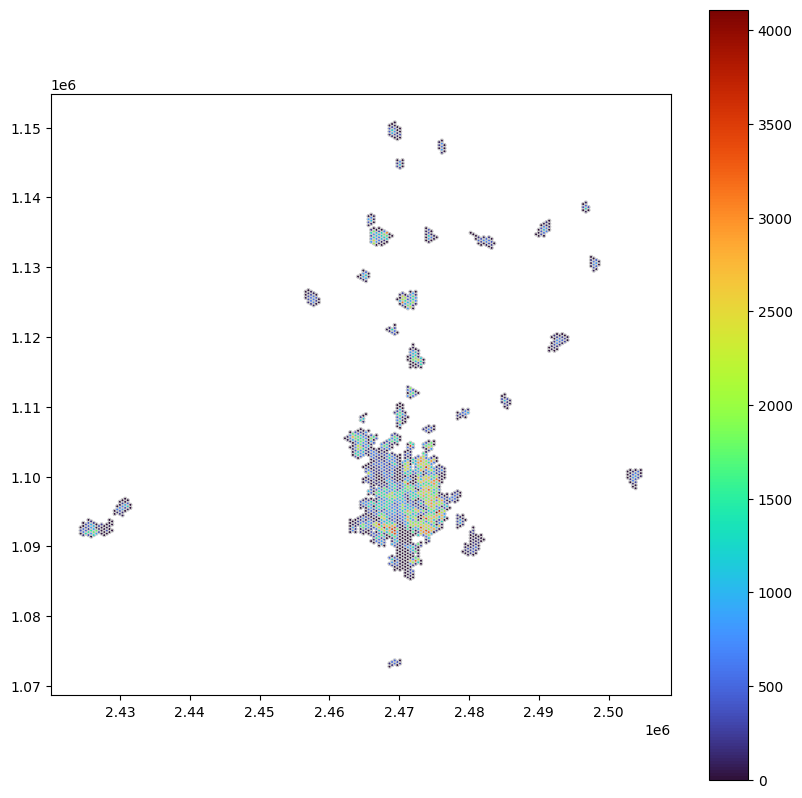

In [58]:
variable = 'PoblacionTotal'
cmap = 'turbo'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Dibuja el mapa.
hex_final.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')

# Agrega una barra de colores.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=hex_final[variable].min(), vmax=hex_final[variable].max()))
sm._A = []  # Esto es solo para evitar un warning al usar matplotlib 3.1.
cbar = fig.colorbar(sm, ax=ax)

# Muestra el mapa.
plt.show()

In [47]:
hex_final

,cell_id,geometry,PoblacionTotal,ViviendasInternet,ViviendasConsola,ViviendasStreaming
0,"6583,4955","POLYGON ((2468500.000 1072572.463, 2468750.000...",0.0,0.0,0.0,0.0
1,"6584,4956","POLYGON ((2468875.000 1072788.969, 2469125.000...",189.0,6.0,0.0,0.0
2,"6583,4957","POLYGON ((2468500.000 1073005.475, 2468750.000...",155.0,16.0,0.0,0.0
3,"6584,4958","POLYGON ((2468875.000 1073221.982, 2469125.000...",539.0,38.0,0.0,0.0
4,"6585,4957","POLYGON ((2469250.000 1073005.475, 2469500.000...",522.0,49.0,6.0,9.0
...,...,...,...,...,...,...
1725,"6584,5312","POLYGON ((2468875.000 1149865.230, 2469125.000...",253.0,32.0,7.0,7.0
1726,"6583,5313","POLYGON ((2468500.000 1150081.736, 2468750.000...",0.0,0.0,0.0,0.0
1727,"6585,5313","POLYGON ((2469250.000 1150081.736, 2469500.000...",57.0,8.0,0.0,0.0
1728,"6584,5314","POLYGON ((2468875.000 1150298.243, 2469125.000...",0.0,0.0,0.0,0.0


### Explicación del código para Visualizar Datos Espaciales con Folium

Este bloque de código muestra cómo visualizar datos espaciales usando `GeoPandas` y `Folium`, que es una biblioteca para la creación de mapas interactivos:

#### Lectura del Archivo Shapefile

```python
hex_final = gpd.read_file("./inegi/mgccpv/shp/hex_data.shp")
```

- Se carga un conjunto de datos geoespaciales desde un archivo shapefile usando `GeoPandas`. El archivo contiene datos en un formato que representa geometrías en una rejilla hexagonal.

#### Configuración de la Variable de Interés

```python
variable = 'PoblacionT'
```

- Se define una variable que identifica la columna de interés dentro del `GeoDataFrame` `hex_final`. Aquí se abrevia debido a la limitación de 10 carácteres a nombres de variables del formato shapefile, refiriéndose a la población total.

#### Establecimiento y Transformación del Sistema de Referencia de Coordenadas (CRS)

```python
hex_final.crs = "EPSG:6372"
hex_final = hex_final.to_crs(epsg=4326)
```

- Se asegura que el `GeoDataFrame` `hex_final` tenga establecido el sistema de referencia de coordenadas correcto (`EPSG:6372`). Si no es el caso, se establece programáticamente.
- Se transforma el sistema de coordenadas a `EPSG:4326`, que es el sistema de referencia común para mapas web y permite la integración con herramientas como Google Maps y Folium.

#### Añadir Columna de Índice

```python
hex_final['index'] = hex_final.index.astype(str)
```

- Se añade una nueva columna `'index'` al `GeoDataFrame`, que será utilizada más adelante por Folium para vincular los datos con la geometría en el mapa (`key_on`).

#### Conversión a Formato JSON

```python
gdf_json = hex_final.to_json()
```

- El `GeoDataFrame` se convierte a formato JSON, que es el formato requerido por Folium para leer los datos geoespaciales y representarlos en el mapa.

#### Cálculo del Centro del Mapa

```python
centroid = hex_final.geometry.centroid
avg_lat = centroid.y.mean()
avg_lon = centroid.x.mean()
```

- Se calcula el centroide de todas las geometrías (los hexágonos) en `hex_final` para determinar el punto central del mapa. Esto asegura que el mapa estará centrado correctamente cuando se visualice.
- `avg_lat` y `avg_lon` son las coordenadas promedio de latitud y longitud, respectivamente, que se utilizan para centrar el mapa de Folium.

#### Creación del Mapa con Folium

```python
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)
```

- Se crea un mapa de Folium centrado en las coordenadas calculadas con un nivel de zoom inicial.

#### Adición de la Capa Choropleth

```python
folium.Choropleth(
    geo_data=gdf_json,
    name='choropleth',
    data=hex_final,
    columns=['index', variable],
    key_on='feature.properties.index',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=variable
).add_to(m)
```

- Se añade una capa Choropleth al mapa, que es una representación visual que utiliza diferentes tonalidades de color para representar la magnitud de la variable de interés (`'PoblacionT'`) en cada hexágono.
- Se especifican las columnas que contienen los identificadores y los valores, la opacidad del relleno y de la línea, y el nombre de la leyenda.
- El argumento `key_on` vincula los datos del `GeoDataFrame` con los hexágonos del mapa.

#### Visualización del Mapa en el Notebook

```python
m
```

- Al final de la clase, se presenta el objeto de mapa `m`. En un entorno de Jupyter Notebook, esta línea mostraría el mapa interactivo directamente en el notebook.

In [59]:
hex_final = gpd.read_file("./inegi/mgccpv/shp/hex_data.shp")
variable = 'PoblacionT'

# Asegúrate de que tu GeoDataFrame tenga el CRS correcto establecido si no lo tiene ya.
hex_final.crs = "EPSG:6372"

# Transforma la proyección a EPSG:4326 para uso en mapas web.
hex_final = hex_final.to_crs(epsg=4326)

# Añade una columna 'index' que será usada por Folium para el key_on en la capa Choropleth.
hex_final['index'] = hex_final.index.astype(str)

# Convertir el GeoDataFrame a formato JSON.
gdf_json = hex_final.to_json()

# Calcula el centro del mapa.
centroid = hex_final.geometry.centroid
avg_lat = centroid.y.mean()
avg_lon = centroid.x.mean()

# Crear el objeto de mapa de Folium.
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

# Agregar la capa Choropleth.
folium.Choropleth(
    geo_data=gdf_json,
    name='choropleth',
    data=hex_final,
    columns=['index', variable],  # Usa 'index' porque ya lo hemos definido anteriormente
    key_on='feature.properties.index',
    fill_color='YlGnBu',  # Puedes cambiar esto para que coincida con la paleta de colores 'turbo' si lo deseas
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=variable
).add_to(m)

# Mostrar el mapa en el notebook.
m



<ipython-input-59-ed4da0fb4a85>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = hex_final.geometry.centroid


In [51]:
hex_final

,cell_id,PoblacionT,ViviendasI,ViviendasC,ViviendasS,geometry,index
0,"6583,4955",0.0,0.0,0.0,0.0,"POLYGON ((-102.30585 21.66798, -102.30707 21.6...",0
1,"6584,4956",189.0,6.0,0.0,0.0,"POLYGON ((-102.30221 21.66995, -102.30343 21.6...",1
2,"6583,4957",155.0,16.0,0.0,0.0,"POLYGON ((-102.30586 21.67191, -102.30708 21.6...",2
3,"6584,4958",539.0,38.0,0.0,0.0,"POLYGON ((-102.30222 21.67388, -102.30344 21.6...",3
4,"6585,4957",522.0,49.0,6.0,9.0,"POLYGON ((-102.29858 21.67193, -102.29980 21.6...",4
...,...,...,...,...,...,...,...
1725,"6584,5312",253.0,32.0,7.0,7.0,"POLYGON ((-102.30380 22.36959, -102.30502 22.3...",1725
1726,"6583,5313",0.0,0.0,0.0,0.0,"POLYGON ((-102.30746 22.37154, -102.30869 22.3...",1726
1727,"6585,5313",57.0,8.0,0.0,0.0,"POLYGON ((-102.30014 22.37156, -102.30137 22.3...",1727
1728,"6584,5314",0.0,0.0,0.0,0.0,"POLYGON ((-102.30381 22.37352, -102.30503 22.3...",1728
